In [2]:
# Google Colab에 NanumGothic 폰트 설치
!apt-get update -qq
!apt-get install fonts-nanum* -qq

# matplotlib.font_manager 임포트
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 설치된 폰트 확인 및 matplotlib에 적용
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')

print("폰트 설정 완료")


Selecting previously unselected package fonts-nanum.
(Reading database ... 121925 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
폰트 설정 완료


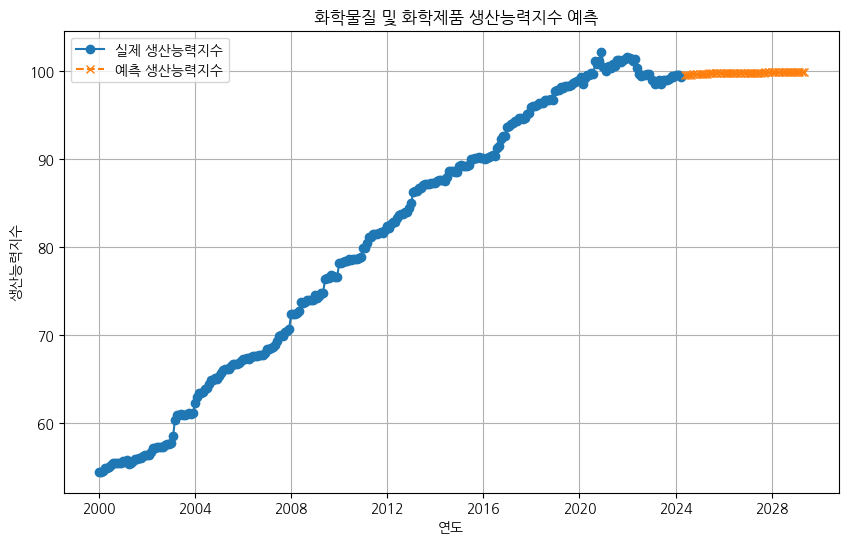

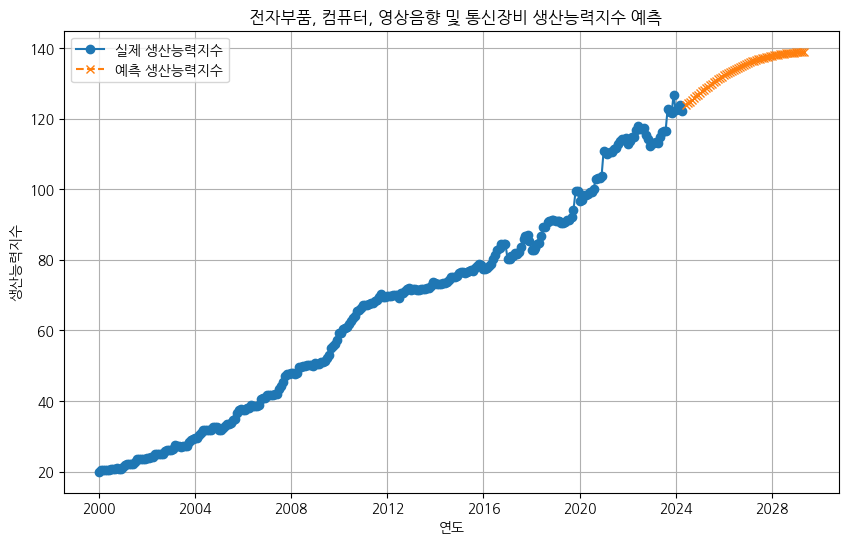

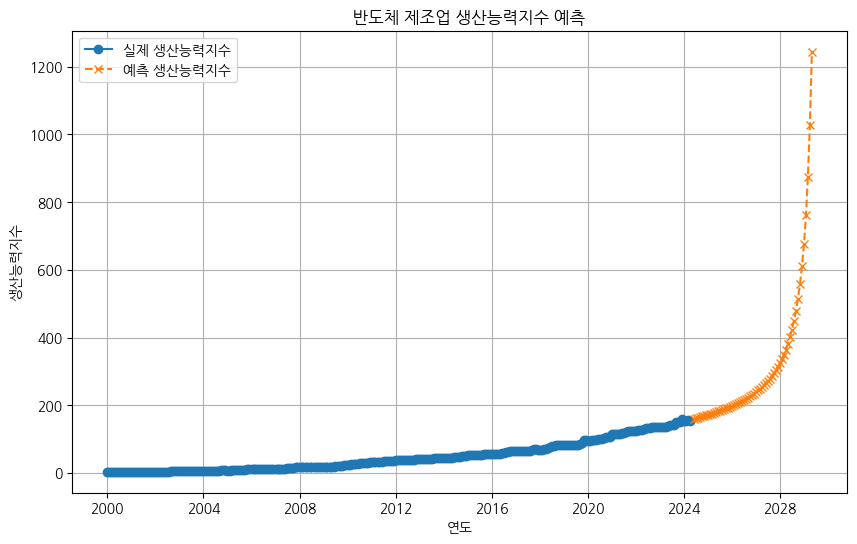

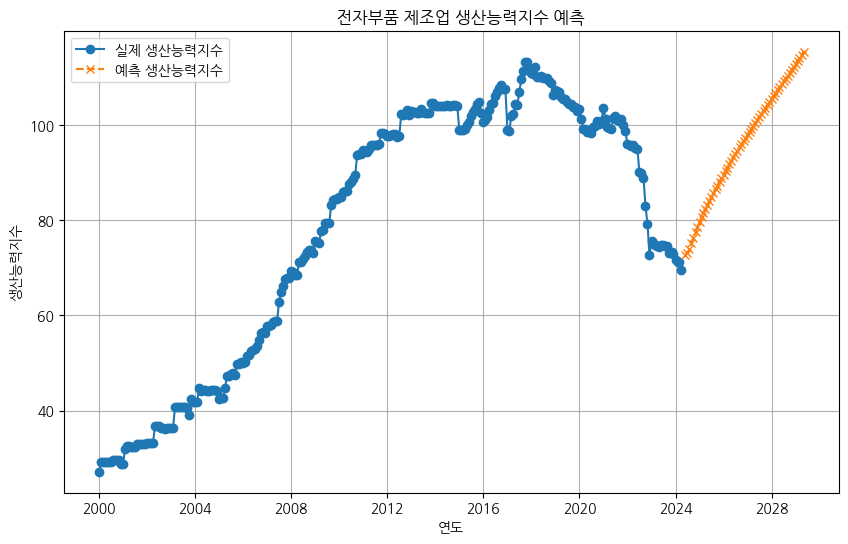

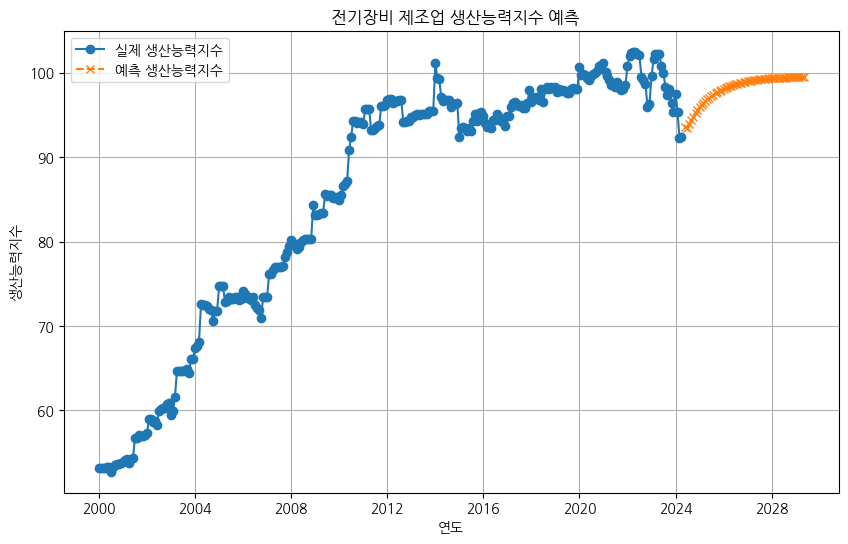

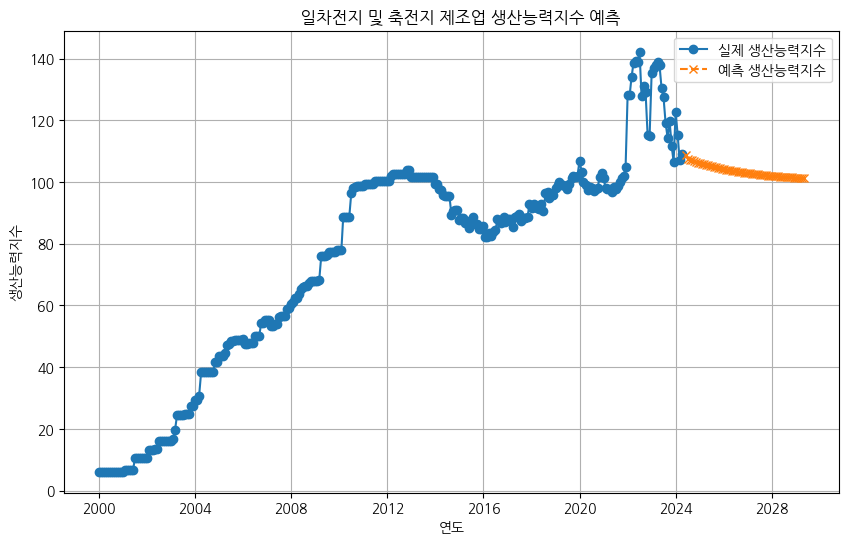

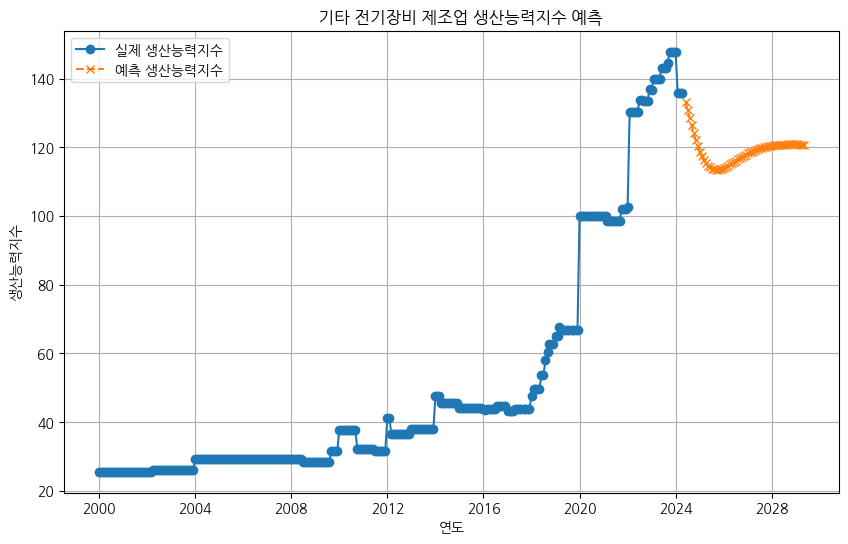

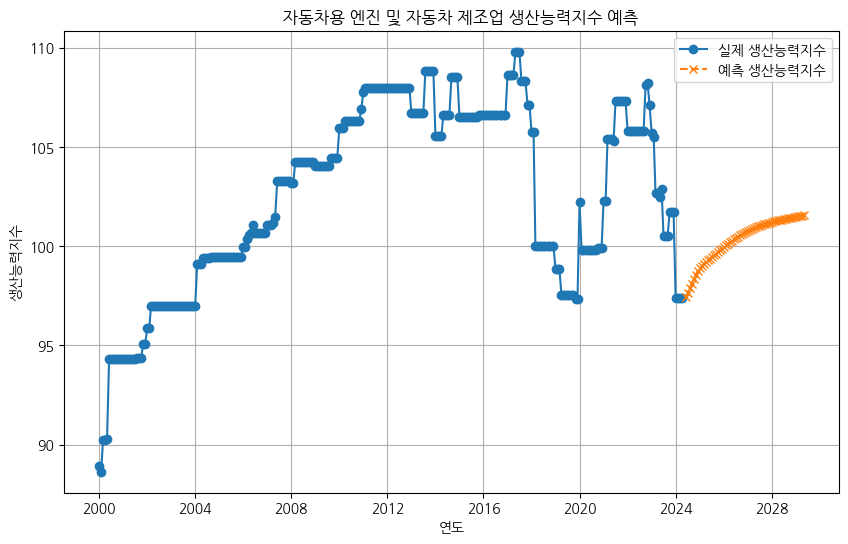

,화학물질 및 화학제품,"전자부품, 컴퓨터, 영상음향 및 통신장비",반도체 제조업,전자부품 제조업,전기장비 제조업,일차전지 및 축전지 제조업,기타 전기장비 제조업,자동차용 엔진 및 자동차 제조업
date,,,,,,,,
2000-01-01,54.478000,19.938000,3.393000,27.150000,53.176000,6.123000,25.498000,88.911000
2000-02-01,54.478000,20.416000,3.393000,29.209000,53.176000,6.123000,25.498000,88.632000
2000-03-01,54.544000,20.424000,3.393000,29.244000,53.231000,6.123000,25.498000,90.207000
2000-04-01,54.870000,20.468000,3.393000,29.244000,53.231000,6.123000,25.498000,90.207000
2000-05-01,54.857000,20.485000,3.394000,29.276000,53.240000,6.123000,25.498000,90.264000
...,...,...,...,...,...,...,...,...
2028-12-31,99.848656,138.746674,676.864807,112.913452,99.482262,101.368675,120.792015,101.479912
2029-01-31,99.848969,138.795639,762.315613,113.541069,99.488724,101.327827,120.784355,101.497520
2029-02-28,99.849228,138.840958,874.992371,114.172127,99.494675,101.288017,120.774185,101.514610


성장률 및 예측 생산능력지수 테이블이 'lstm_growth_rates_and_forecasts.csv' 파일로 저장되었습니다.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# CSV 파일 읽기
df = pd.read_csv('/content/생산능력지수.csv')

# 날짜 형식을 datetime으로 변환
df['date'] = pd.to_datetime(df['date'], format='%Y/%m')

# 결과 저장용 데이터프레임
all_forecasts = []

# LSTM 모델을 위한 데이터 준비 함수
def prepare_data(series, n_steps):
    X, y = [], []
    for i in range(len(series)):
        end_ix = i + n_steps
        if end_ix > len(series) - 1:
            break
        seq_x, seq_y = series[i:end_ix], series[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# LSTM 모델 학습 및 예측 함수
def lstm_forecast(series, n_steps, n_forecast):
    scaler = MinMaxScaler(feature_range=(0, 1))
    series_scaled = scaler.fit_transform(series.values.reshape(-1, 1))
    X, y = prepare_data(series_scaled, n_steps)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=300, verbose=0)

    x_input = series_scaled[-n_steps:].reshape((1, n_steps, 1))
    forecast = []
    for _ in range(n_forecast):
        yhat = model.predict(x_input, verbose=0)
        forecast.append(yhat[0][0])
        x_input = np.append(x_input[:, 1:, :], yhat.reshape((1, 1, 1)), axis=1)

    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()
    return forecast

# 모든 열에 대해 LSTM 모델을 적용
n_steps = 12  # 과거 12개월 데이터 사용
n_forecast = 60  # 향후 60개월 예측
prediction_months = pd.date_range(start='2024-05', periods=n_forecast, freq='M')

for column in df.columns[1:]:
    series = df[column]
    forecast = lstm_forecast(series, n_steps, n_forecast)

    forecast_df = pd.DataFrame({'date': prediction_months, column: forecast})
    all_forecasts.append(forecast_df.set_index('date'))

    # 예측 결과 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(df['date'], df[column], marker='o', label='실제 생산능력지수')
    plt.plot(prediction_months, forecast, marker='x', linestyle='--', label='예측 생산능력지수')
    plt.title(f'{column} 생산능력지수 예측')
    plt.xlabel('연도')
    plt.ylabel('생산능력지수')
    plt.legend()
    plt.grid(True)
    plt.show()

# 모든 예측 결과 병합
final_forecast = pd.concat(all_forecasts, axis=1)

# 성장률 계산
growth_rates = final_forecast.pct_change() * 100

# 성장률 및 예측 생산능력지수 테이블 저장
result = pd.concat([df.set_index('date'), final_forecast])
growth_rates.to_csv('lstm_growth_rates_and_forecasts.csv')

# 성장률 및 예측 생산능력지수 테이블 출력
from IPython.display import display
display(result)

print("성장률 및 예측 생산능력지수 테이블이 'lstm_growth_rates_and_forecasts.csv' 파일로 저장되었습니다.")


## 생산능력지수 (Capacity Index):

  - 정의: 생산능력지수는 한 나라의 산업이 최대한 생산할 수 있는 능력을 지수화한 것입니다. 즉, 산업의 설비와 자본이 최대한 가동되었을 때의 생산 능력을 측정합니다.
  - 용도: 이 지수는 경제의 생산 잠재력을 파악하는 데 도움이 됩니다. 생산능력의 변화는 새로운 설비 투자, 기술 혁신, 또는 기존 설비의 폐기 등에 의해 발생할 수 있습니다.
  - 계산 방법: 기준년도 2020년의 생산능력을 100으로 두고, 비교 연도의 생산능력을 상대적으로 나타냅니다.

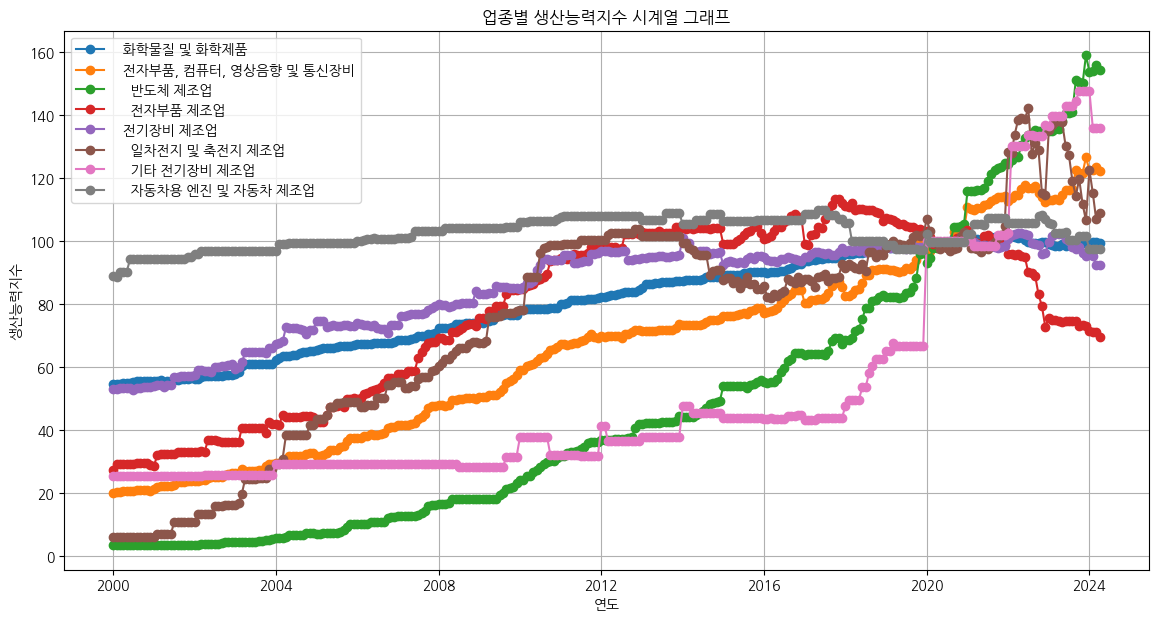

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 읽기
df = pd.read_csv('/content/생산능력지수.csv', index_col='date')

# 인덱스를 datetime 형식으로 변환
df.index = pd.to_datetime(df.index, format='%Y/%m')

# 업종별 생산능력지수 시계열 그래프
plt.figure(figsize=(14, 7))
for column in df.columns:
    plt.plot(df.index, df[column], marker='o', label=column)
plt.title('업종별 생산능력지수 시계열 그래프')
plt.xlabel('연도')
plt.ylabel('생산능력지수')
plt.legend()
plt.grid(True)
plt.show()
